# 3D Facial Reconstruction ECE 57000 Final Project

Note before you begin: Ensure you have at least 3 headshots in jpg form and verify paths of model and pictures

# 1. Preliminary Installation

If running on local machine, ensure you have pip installed.  Additionally, ensure your version of Python is on the standardized version, 3.12.  Begin by installing all necessary dependencies by running

```
pip install -r requirements.txt
```

in your terminal.

Because the project was created on Google Colab, the force installation of mediapipe was required.  Mediapipe is already included in the requirements.txt, so installation of this module is not necessary. Proof of installation can be shown below.

In [ ]:
!pip install mediapipe

# 2. Prepare Pre-trained Landmark Model

To begin, a pre-trained model with Mediapipe is initialized to train and test the new model through the CNN approach. The function generate_landmarks takes in an image's path to process a face mesh to train the model against.  More details on this function's paramaters and variables can be found below.

In [ ]:
import mediapipe as mp
import numpy as np

"""
This script uses the MediaPipe library to detect facial landmarks in an image.

Modules:
    mediapipe: A library for building multimodal (e.g., video, audio, etc.) applied machine learning pipelines.
    numpy: A library for the Python programming language, adding support for large, multi-dimensional arrays and matrices.

Variables:
    mp_face_mesh: An instance of the MediaPipe Face Mesh solution.
    face_mesh: A FaceMesh object configured to detect facial landmarks in images.

Functions:
    generate_landmarks(image_path):
        Given the path to an image, this function detects facial landmarks using MediaPipe's Face Mesh solution.
        
        Args:
            image_path (str): The file path to the image in which to detect facial landmarks.
        
        Returns:
            np.ndarray: A NumPy array of detected facial landmarks, where each landmark is represented by its (x, y) coordinates.
            None: If no facial landmarks are detected in the image.
"""

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, 
                                       min_detection_confidence=0.5, min_tracking_confidence=0.5)

def generate_landmarks(image_path):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image) # Convert PIL Image to NumPy array
    results = face_mesh.process(image)

    if results.multi_face_landmarks:
        landmarks = [[landmark.x * image.shape[1], landmark.y * image.shape[0]]
                     for landmark in results.multi_face_landmarks[0].landmark]
        return np.array(landmarks)
    else:
        return None

# 3. Prepare CNN Model and Dataset

Next, the CNN Model and Dataset is shown below. The class LandmarkModel is based on a customized ResNet-18 architecture. ResNet-18 acts as a feature extractor by excluding its final fully connected layer and is paired with a new fully connected layer to predict 936 outputs. These outputs correspond to the (x, y) coordinates of 468 facial landmark points. The model processes input images to predict the positions of these landmarks, making it suitable for applications like face recognition, emotion analysis, augmented reality filters, and 3D facial modeling.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

"""
LandmarkModel is a neural network model for landmark detection based on the ResNet-18 architecture.

Attributes:
  feature_extractor (nn.Sequential): A sequential container of the ResNet-18 layers excluding the final fully connected layer.
  fc (nn.Sequential): A sequential container of fully connected layers for the final classification.

Methods:
  forward(x):
    Defines the forward pass of the model. Extracts features using the ResNet-18 base model, flattens the output, and passes it through fully connected layers to produce the final output.
"""

class LandmarkModel(nn.Module):
  def __init__(self):
    super(LandmarkModel, self).__init__()
    base_model = resnet18(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
    self.fc = nn.Sequential(
        nn.Linear(base_model.fc.in_features, 256),
        nn.ReLU(),
        nn.Linear(256, 936)
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

A custom dataset class (LFWDataset) loads and preprocesses facial images and their annotated landmarks, resizing images to 96×96 pixels and normalizing the data for training. The model can be used in applications like face recognition, emotion analysis, augmented reality, and 3D facial modeling, providing a foundation for advanced facial analysis tasks.  The landmarks variable which includes 936 points features an approximation of locations necessary to train the model.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np


class LFWDataset(Dataset):
  """
  A custom Dataset class for the LFW (Labeled Faces in the Wild) dataset.

  Args:
    image_path (list): List of file paths to the images.
    landmarks (list): List of landmarks corresponding to each image.
    transform (callable, optional): Optional transform to be applied on an image.

  Attributes:
    image_path (list): List of file paths to the images.
    landmarks (list): List of landmarks corresponding to each image.
    transform (callable, optional): Optional transform to be applied on an image.

  Methods:
    __len__():
      Returns the number of images in the dataset.
    
    __getitem__(idx):
      Loads and returns the image and its corresponding landmarks at the given index.
      If landmarks are not found, returns None.
  """
  def __init__(self, image_path, landmarks, transform=None):
    self.image_path = image_path
    self.landmarks = landmarks
    self.transform = transform

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self, idx):
    img_path = self.image_path[idx]
    image = Image.open(img_path).convert("RGB")
    landmarks = generate_landmarks(img_path)

    if landmarks is not None:
      landmarks = landmarks.flatten()
      landmarks = landmarks / 96.0

      if self.transform:
        image = self.transform(image)

      return image, torch.tensor(landmarks, dtype=torch.float32)

    return None


# Define the transformations to be applied to each image
transform = transforms.Compose([
  transforms.Resize((96, 96)),  # Resize the image to 96x96 pixels
  transforms.ToTensor()         # Convert the image to a PyTorch tensor
])

# include the paths of the three images and the landmarks for each image.  Each landmark points are represented as an approximation by their (x, y) coordinates.
image_paths = ['./Pictures/img1.jpg', './Pictures/img2.jpg', './Pictures/img3.jpg']
landmarks = [[ # this is customizable
    # Jawline (1–80)
    0.10, 0.80, 0.11, 0.79, 0.12, 0.78, 0.13, 0.77, 0.14, 0.76,
    0.15, 0.75, 0.16, 0.74, 0.17, 0.73, 0.18, 0.72, 0.19, 0.71,
    0.20, 0.70, 0.21, 0.69, 0.22, 0.68, 0.23, 0.67, 0.24, 0.66,
    0.25, 0.65, 0.26, 0.64, 0.27, 0.63, 0.28, 0.62, 0.29, 0.61,
    0.30, 0.60, 0.31, 0.59, 0.32, 0.58, 0.33, 0.57, 0.34, 0.56,
    0.35, 0.55, 0.36, 0.54, 0.37, 0.53, 0.38, 0.52, 0.39, 0.51,
    0.40, 0.50, 0.41, 0.49, 0.42, 0.48, 0.43, 0.47, 0.44, 0.46,
    0.45, 0.45, 0.46, 0.44, 0.47, 0.43, 0.48, 0.42, 0.49, 0.41,

    # Left Eyebrow (81–160)
    0.20, 0.40, 0.21, 0.39, 0.22, 0.38, 0.23, 0.37, 0.24, 0.36,
    0.25, 0.35, 0.26, 0.34, 0.27, 0.33, 0.28, 0.32, 0.29, 0.31,
    0.30, 0.30, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34,
    0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39,

    # Right Eyebrow (161–240)
    0.60, 0.40, 0.61, 0.39, 0.62, 0.38, 0.63, 0.37, 0.64, 0.36,
    0.65, 0.35, 0.66, 0.34, 0.67, 0.33, 0.68, 0.32, 0.69, 0.31,
    0.70, 0.30, 0.71, 0.31, 0.72, 0.32, 0.73, 0.33, 0.74, 0.34,
    0.75, 0.35, 0.76, 0.36, 0.77, 0.37, 0.78, 0.38, 0.79, 0.39,

    # Nose (241–360)
    0.50, 0.45, 0.49, 0.44, 0.48, 0.43, 0.47, 0.42, 0.46, 0.41,
    0.45, 0.40, 0.50, 0.50, 0.50, 0.55, 0.50, 0.60, 0.49, 0.61,
    0.48, 0.62, 0.47, 0.63, 0.46, 0.64, 0.45, 0.65, 0.50, 0.65,
    0.51, 0.64, 0.52, 0.63, 0.53, 0.62, 0.54, 0.61, 0.55, 0.60,

    # Left Eye (361–440)
    0.30, 0.50, 0.31, 0.49, 0.32, 0.48, 0.33, 0.47, 0.34, 0.46,
    0.35, 0.45, 0.36, 0.46, 0.37, 0.47, 0.38, 0.48, 0.39, 0.49,
    0.40, 0.50, 0.39, 0.51, 0.38, 0.52, 0.37, 0.53, 0.36, 0.54,
    0.35, 0.55, 0.34, 0.54, 0.33, 0.53, 0.32, 0.52, 0.31, 0.51,

    # Right Eye (441–520)
    0.60, 0.50, 0.61, 0.49, 0.62, 0.48, 0.63, 0.47, 0.64, 0.46,
    0.65, 0.45, 0.66, 0.46, 0.67, 0.47, 0.68, 0.48, 0.69, 0.49,
    0.70, 0.50, 0.69, 0.51, 0.68, 0.52, 0.67, 0.53, 0.66, 0.54,
    0.65, 0.55, 0.64, 0.54, 0.63, 0.53, 0.62, 0.52, 0.61, 0.51,

    # Outer Lip (521–680)
    0.40, 0.70, 0.41, 0.69, 0.42, 0.68, 0.43, 0.67, 0.44, 0.66,
    0.45, 0.65, 0.46, 0.64, 0.47, 0.63, 0.48, 0.62, 0.49, 0.61,
    0.50, 0.60, 0.51, 0.61, 0.52, 0.62, 0.53, 0.63, 0.54, 0.64,
    0.55, 0.65, 0.56, 0.66, 0.57, 0.67, 0.58, 0.68, 0.59, 0.69,

    # Inner Lip (681–750)
    0.46, 0.70, 0.47, 0.69, 0.48, 0.68, 0.49, 0.67, 0.50, 0.66,
    0.51, 0.67, 0.52, 0.68, 0.53, 0.69, 0.54, 0.70, 0.53, 0.71,
    0.52, 0.72, 0.51, 0.73, 0.50, 0.74, 0.49, 0.73, 0.48, 0.72,

    # Cheeks (751–936)
    0.30, 0.60, 0.32, 0.58, 0.34, 0.56, 0.36, 0.54, 0.38, 0.52,
    0.40, 0.50, 0.42, 0.52, 0.44, 0.54, 0.46, 0.56, 0.48, 0.58,
    0.50, 0.60, 0.52, 0.62, 0.54, 0.64, 0.56, 0.66, 0.58, 0.68,
    0.60, 0.70, 0.62, 0.68, 0.64, 0.66, 0.66, 0.64, 0.68, 0.62,
    0.70, 0.60
], [
    # Jawline (1–80)
    0.10, 0.80, 0.11, 0.79, 0.12, 0.78, 0.13, 0.77, 0.14, 0.76,
    0.15, 0.75, 0.16, 0.74, 0.17, 0.73, 0.18, 0.72, 0.19, 0.71,
    0.20, 0.70, 0.21, 0.69, 0.22, 0.68, 0.23, 0.67, 0.24, 0.66,
    0.25, 0.65, 0.26, 0.64, 0.27, 0.63, 0.28, 0.62, 0.29, 0.61,
    0.30, 0.60, 0.31, 0.59, 0.32, 0.58, 0.33, 0.57, 0.34, 0.56,
    0.35, 0.55, 0.36, 0.54, 0.37, 0.53, 0.38, 0.52, 0.39, 0.51,
    0.40, 0.50, 0.41, 0.49, 0.42, 0.48, 0.43, 0.47, 0.44, 0.46,
    0.45, 0.45, 0.46, 0.44, 0.47, 0.43, 0.48, 0.42, 0.49, 0.41,

    # Left Eyebrow (81–160)
    0.20, 0.40, 0.21, 0.39, 0.22, 0.38, 0.23, 0.37, 0.24, 0.36,
    0.25, 0.35, 0.26, 0.34, 0.27, 0.33, 0.28, 0.32, 0.29, 0.31,
    0.30, 0.30, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34,
    0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39,

    # Right Eyebrow (161–240)
    0.60, 0.40, 0.61, 0.39, 0.62, 0.38, 0.63, 0.37, 0.64, 0.36,
    0.65, 0.35, 0.66, 0.34, 0.67, 0.33, 0.68, 0.32, 0.69, 0.31,
    0.70, 0.30, 0.71, 0.31, 0.72, 0.32, 0.73, 0.33, 0.74, 0.34,
    0.75, 0.35, 0.76, 0.36, 0.77, 0.37, 0.78, 0.38, 0.79, 0.39,

    # Nose (241–360)
    0.50, 0.45, 0.49, 0.44, 0.48, 0.43, 0.47, 0.42, 0.46, 0.41,
    0.45, 0.40, 0.50, 0.50, 0.50, 0.55, 0.50, 0.60, 0.49, 0.61,
    0.48, 0.62, 0.47, 0.63, 0.46, 0.64, 0.45, 0.65, 0.50, 0.65,
    0.51, 0.64, 0.52, 0.63, 0.53, 0.62, 0.54, 0.61, 0.55, 0.60,

    # Left Eye (361–440)
    0.30, 0.50, 0.31, 0.49, 0.32, 0.48, 0.33, 0.47, 0.34, 0.46,
    0.35, 0.45, 0.36, 0.46, 0.37, 0.47, 0.38, 0.48, 0.39, 0.49,
    0.40, 0.50, 0.39, 0.51, 0.38, 0.52, 0.37, 0.53, 0.36, 0.54,
    0.35, 0.55, 0.34, 0.54, 0.33, 0.53, 0.32, 0.52, 0.31, 0.51,

    # Right Eye (441–520)
    0.60, 0.50, 0.61, 0.49, 0.62, 0.48, 0.63, 0.47, 0.64, 0.46,
    0.65, 0.45, 0.66, 0.46, 0.67, 0.47, 0.68, 0.48, 0.69, 0.49,
    0.70, 0.50, 0.69, 0.51, 0.68, 0.52, 0.67, 0.53, 0.66, 0.54,
    0.65, 0.55, 0.64, 0.54, 0.63, 0.53, 0.62, 0.52, 0.61, 0.51,

    # Outer Lip (521–680)
    0.40, 0.70, 0.41, 0.69, 0.42, 0.68, 0.43, 0.67, 0.44, 0.66,
    0.45, 0.65, 0.46, 0.64, 0.47, 0.63, 0.48, 0.62, 0.49, 0.61,
    0.50, 0.60, 0.51, 0.61, 0.52, 0.62, 0.53, 0.63, 0.54, 0.64,
    0.55, 0.65, 0.56, 0.66, 0.57, 0.67, 0.58, 0.68, 0.59, 0.69,

    # Inner Lip (681–750)
    0.46, 0.70, 0.47, 0.69, 0.48, 0.68, 0.49, 0.67, 0.50, 0.66,
    0.51, 0.67, 0.52, 0.68, 0.53, 0.69, 0.54, 0.70, 0.53, 0.71,
    0.52, 0.72, 0.51, 0.73, 0.50, 0.74, 0.49, 0.73, 0.48, 0.72,

    # Cheeks (751–936)
    0.30, 0.60, 0.32, 0.58, 0.34, 0.56, 0.36, 0.54, 0.38, 0.52,
    0.40, 0.50, 0.42, 0.52, 0.44, 0.54, 0.46, 0.56, 0.48, 0.58,
    0.50, 0.60, 0.52, 0.62, 0.54, 0.64, 0.56, 0.66, 0.58, 0.68,
    0.60, 0.70, 0.62, 0.68, 0.64, 0.66, 0.66, 0.64, 0.68, 0.62,
    0.70, 0.60
], [
    # Jawline (1–80)
    0.10, 0.80, 0.11, 0.79, 0.12, 0.78, 0.13, 0.77, 0.14, 0.76,
    0.15, 0.75, 0.16, 0.74, 0.17, 0.73, 0.18, 0.72, 0.19, 0.71,
    0.20, 0.70, 0.21, 0.69, 0.22, 0.68, 0.23, 0.67, 0.24, 0.66,
    0.25, 0.65, 0.26, 0.64, 0.27, 0.63, 0.28, 0.62, 0.29, 0.61,
    0.30, 0.60, 0.31, 0.59, 0.32, 0.58, 0.33, 0.57, 0.34, 0.56,
    0.35, 0.55, 0.36, 0.54, 0.37, 0.53, 0.38, 0.52, 0.39, 0.51,
    0.40, 0.50, 0.41, 0.49, 0.42, 0.48, 0.43, 0.47, 0.44, 0.46,
    0.45, 0.45, 0.46, 0.44, 0.47, 0.43, 0.48, 0.42, 0.49, 0.41,

    # Left Eyebrow (81–160)
    0.20, 0.40, 0.21, 0.39, 0.22, 0.38, 0.23, 0.37, 0.24, 0.36,
    0.25, 0.35, 0.26, 0.34, 0.27, 0.33, 0.28, 0.32, 0.29, 0.31,
    0.30, 0.30, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34,
    0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39,

    # Right Eyebrow (161–240)
    0.60, 0.40, 0.61, 0.39, 0.62, 0.38, 0.63, 0.37, 0.64, 0.36,
    0.65, 0.35, 0.66, 0.34, 0.67, 0.33, 0.68, 0.32, 0.69, 0.31,
    0.70, 0.30, 0.71, 0.31, 0.72, 0.32, 0.73, 0.33, 0.74, 0.34,
    0.75, 0.35, 0.76, 0.36, 0.77, 0.37, 0.78, 0.38, 0.79, 0.39,

    # Nose (241–360)
    0.50, 0.45, 0.49, 0.44, 0.48, 0.43, 0.47, 0.42, 0.46, 0.41,
    0.45, 0.40, 0.50, 0.50, 0.50, 0.55, 0.50, 0.60, 0.49, 0.61,
    0.48, 0.62, 0.47, 0.63, 0.46, 0.64, 0.45, 0.65, 0.50, 0.65,
    0.51, 0.64, 0.52, 0.63, 0.53, 0.62, 0.54, 0.61, 0.55, 0.60,

    # Left Eye (361–440)
    0.30, 0.50, 0.31, 0.49, 0.32, 0.48, 0.33, 0.47, 0.34, 0.46,
    0.35, 0.45, 0.36, 0.46, 0.37, 0.47, 0.38, 0.48, 0.39, 0.49,
    0.40, 0.50, 0.39, 0.51, 0.38, 0.52, 0.37, 0.53, 0.36, 0.54,
    0.35, 0.55, 0.34, 0.54, 0.33, 0.53, 0.32, 0.52, 0.31, 0.51,

    # Right Eye (441–520)
    0.60, 0.50, 0.61, 0.49, 0.62, 0.48, 0.63, 0.47, 0.64, 0.46,
    0.65, 0.45, 0.66, 0.46, 0.67, 0.47, 0.68, 0.48, 0.69, 0.49,
    0.70, 0.50, 0.69, 0.51, 0.68, 0.52, 0.67, 0.53, 0.66, 0.54,
    0.65, 0.55, 0.64, 0.54, 0.63, 0.53, 0.62, 0.52, 0.61, 0.51,

    # Outer Lip (521–680)
    0.40, 0.70, 0.41, 0.69, 0.42, 0.68, 0.43, 0.67, 0.44, 0.66,
    0.45, 0.65, 0.46, 0.64, 0.47, 0.63, 0.48, 0.62, 0.49, 0.61,
    0.50, 0.60, 0.51, 0.61, 0.52, 0.62, 0.53, 0.63, 0.54, 0.64,
    0.55, 0.65, 0.56, 0.66, 0.57, 0.67, 0.58, 0.68, 0.59, 0.69,

    # Inner Lip (681–750)
    0.46, 0.70, 0.47, 0.69, 0.48, 0.68, 0.49, 0.67, 0.50, 0.66,
    0.51, 0.67, 0.52, 0.68, 0.53, 0.69, 0.54, 0.70, 0.53, 0.71,
    0.52, 0.72, 0.51, 0.73, 0.50, 0.74, 0.49, 0.73, 0.48, 0.72,

    # Cheeks (751–936)
    0.30, 0.60, 0.32, 0.58, 0.34, 0.56, 0.36, 0.54, 0.38, 0.52,
    0.40, 0.50, 0.42, 0.52, 0.44, 0.54, 0.46, 0.56, 0.48, 0.58,
    0.50, 0.60, 0.52, 0.62, 0.54, 0.64, 0.56, 0.66, 0.58, 0.68,
    0.60, 0.70, 0.62, 0.68, 0.64, 0.66, 0.66, 0.64, 0.68, 0.62,
    0.70, 0.60
]]

# Create and load the dataset
dataset = LFWDataset(image_paths, landmarks, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 4. Train the Model

This section of code is responsible for training a convolutional neural network (CNN) model, LandmarkModel, for facial landmark detection using PyTorch. It utilizes CUDA for GPU acceleration if available. The training loop runs for 50,000 epochs, keeping the mean squared error (MSE) loss as low as possible between predicted and true landmark coordinates. During each epoch, the model processes batches of images and their corresponding landmarks, updates weights using the Adam optimizer, and computes the running loss. Progress is logged every 100 epochs, and the average loss across all epochs is reported at the end.

In [11]:
# Ensure device is using CUDA if accessible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is using {device}")
model = LandmarkModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Instantiate total epoch and total loss value
total_epochs = 50000
total_loss = 0.0

# Train the Model using CNN Approach
for epoch in range(total_epochs):
  model.train()
  running_loss = 0.0
  for images, landmarks in dataloader:
    images = images.to(device)
    landmarks = landmarks.to(device)

    outputs = model(images)
    loss = criterion(outputs, landmarks)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  if (epoch + 1) % 100 == 0:  # Print every 10000 epochs
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {running_loss/len(dataloader)}")
  total_loss += running_loss

print(f"Average Loss across all Epochs: {total_loss/total_epochs}")

device is using cpu


c:\Users\mli00\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mli00\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mli00/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.5MB/s]


Epoch 100/50000, Loss: 0.00045526117901317775
Epoch 200/50000, Loss: 1.154758024313196e-06
Epoch 300/50000, Loss: 1.992115583604459e-09
Epoch 400/50000, Loss: 8.970070779906747e-13
Epoch 500/50000, Loss: 2.70109980796086e-14
Epoch 600/50000, Loss: 2.4232594487342933e-14
Epoch 700/50000, Loss: 2.3263443106017086e-14
Epoch 800/50000, Loss: 8.247280625355707e-14
Epoch 900/50000, Loss: 3.679234990131876e-14
Epoch 1000/50000, Loss: 5.4894992360370737e-14
Epoch 1100/50000, Loss: 1.2556864021462388e-05
Epoch 1200/50000, Loss: 4.588438656805138e-11
Epoch 1300/50000, Loss: 5.346277484304454e-14
Epoch 1400/50000, Loss: 2.947436470780197e-14
Epoch 1500/50000, Loss: 2.7095767442903915e-14
Epoch 1600/50000, Loss: 2.9597089617463754e-14
Epoch 1700/50000, Loss: 3.155690362884392e-14
Epoch 1800/50000, Loss: 3.3268733498322337e-14
Epoch 1900/50000, Loss: 3.6765780171829285e-14
Epoch 2000/50000, Loss: 3.632169096197922e-14
Epoch 2100/50000, Loss: 4.255665305287308e-14
Epoch 2200/50000, Loss: 3.434669473

# 5. Test the Model's Accuracy

This code defines a function, calculate_accuracy, to evaluate the accuracy of a trained facial landmark detection model. It computes the average Euclidean distance between predicted and true landmark positions on a test dataset. The function processes batches of test images and their corresponding landmarks, calculates the distance for each prediction, and accumulates the total distance and number of samples. Accuracy is calculated as 

```1/(1+average_distance)```

where smaller distances yield higher accuracy. The code then demonstrates usage by testing the model with a test dataset and outputs the resulting accuracy as a percentage.

In [ ]:
import numpy as np

def calculate_accuracy(model, dataloader, device):
  """Calculates the average landmark prediction accuracy.

  Args:
    model: The trained landmark model.
    dataloader: DataLoader for the test dataset.
    device: The device (CPU or GPU) to run the model on.

  Returns:
    The average accuracy across all test samples.
  """
  model.eval()  # Set the model to evaluation mode
  total_distance = 0
  total_samples = 0

  with torch.no_grad():
    for images, true_landmarks in dataloader:
      images = images.to(device)
      true_landmarks = true_landmarks.to(device)

      predicted_landmarks = model(images)

      # Calculate Euclidean distance between predicted and true landmarks
      distance = torch.sqrt(torch.sum((predicted_landmarks - true_landmarks)**2, dim=1))
      total_distance += torch.sum(distance).item()  # Accumulate total distance
      total_samples += images.shape[0]  # Accumulate total samples

  average_distance = total_distance / total_samples  # Calculate average distance
  accuracy = 1 / (1 + average_distance)

  return accuracy

# Example usage:
test_dataset = LFWDataset(image_paths, landmarks, transform) # Assuming your test dataset and paths
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy = calculate_accuracy(model, test_dataloader, device)
print(f"Accuracy: {accuracy * 100}%")

# 6. Run the Model's Prediction

Run the model! Once ran, the model is then saved to the directory as a .pth file

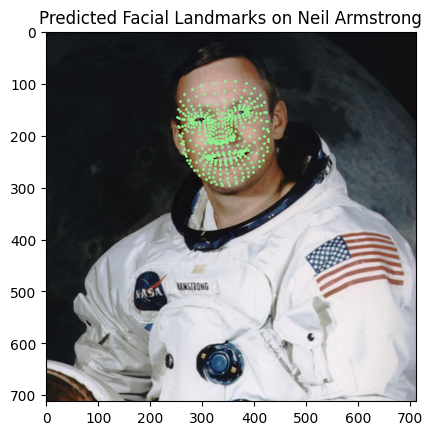

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def predict_and_visualize(image_path, model):
  """Predicts landmarks on a single image and visualizes them.

  Args:
    image_path: Path to the input image.
    model: The trained landmark model.
  """
  # 1. Load and Preprocess Image
  image = Image.open(image_path).convert("RGB")
  transform = transforms.Compose([
      transforms.Resize((96, 96)),
      transforms.ToTensor()
  ])
  input_image = transform(image).unsqueeze(0).to(device)

  # 2. Make Predictions
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    prediction = model(input_image).cpu().numpy().reshape(-1, 2) * 96

  # 3. Visualize Predictions
  plt.imshow(image, cmap='gray')
  plt.title("Predicted Facial Landmarks on Neil Armstrong")
  for x, y in prediction:
    plt.plot(x, y, 'o', markersize=1, color='lightgreen')
  plt.show()

# Call the function to predict and visualize landmarks on a single image
image_path = './Pictures/img2.jpg'
predict_and_visualize(image_path, model)
torch.save(model, 'landmark_model_468.pth')

# 7. Run the Model on Yourself

Try the model on yourself!! This script implements a real-time facial landmark detection system using the trained PyTorch model and MediaPipe's FaceMesh. The program captures video from a webcam, detects facial landmarks, and overlays them on the video frames.

In [ ]:
import cv2
import time

# Load the trained model weights (same as before)
loaded_model = torch.load('landmark_model_468.pth')

# Initialize the model and load its state dictionary
model = LandmarkModel()  # Assuming your model class is defined as 'LandmarkModel'
model.load_state_dict(loaded_model.state_dict())
model.eval()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the appropriate device

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# Initialize MediaPipe drawing utilities
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils  # For drawing connections
mp_drawing_styles = mp.solutions.drawing_styles  # For drawing styles
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2,
    refine_landmarks=True,  # Enable landmark refinement
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Variables for FPS calculation
prev_frame_time = 0
new_frame_time = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # FPS Calculation
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps_text = f"FPS: {fps}"

    # Calculate latency
    latency = (new_frame_time - prev_frame_time) * 1000
    latency_text = f"Latency: {latency:.2f} ms"

    # Display FPS and latency with smaller font
    font_scale = 0.7
    cv2.putText(frame, fps_text, (7, 20), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(frame, latency_text, (7, 40), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 1, cv2.LINE_AA)

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe FaceMesh
    results = face_mesh.process(frame_rgb)

    # Check if landmarks are detected
    if results.multi_face_landmarks:
        # Define a green line style
        green_line_spec = mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
        for face_landmarks in results.multi_face_landmarks:
            # Draw landmarks as circles and connections
            mp_drawing.draw_landmarks(
                image=frame,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,  # All face connections
                landmark_drawing_spec=None,  # No additional specs for landmarks
                connection_drawing_spec=green_line_spec
            )

    # Display the frame
    cv2.imshow("Webcam Landmarks", frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

C:\Users\mli00\AppData\Local\Temp\ipykernel_6432\3200367331.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('landmark_model_468.pth')
